# Regularized Linear Regression

In [27]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

In [28]:
data = loadmat('5. Regularized Linear Regression and Bias -Variance/ex5/ex5data1.mat')
data.keys()

dict_keys(['__globals__', 'X', '__version__', 'yval', '__header__', 'Xtest', 'ytest', 'y', 'Xval'])

In [29]:
y_train = data['y']
X_train = np.c_[np.ones_like(data['X']), data['X']]

yval = data['yval']
Xval = np.c_[np.ones_like(data['Xval']), data['Xval']]


print('X_train:', X_train.shape,'y_train:', y_train.shape)
print('Xval:', Xval.shape,'yval:', yval.shape)

X_train: (12, 2) y_train: (12, 1)
Xval: (21, 2) yval: (21, 1)


**plt.scatter** allows you to specify a different colour and a different size for each point individually. It is not possible to do that with plot.
In **plt.plot**, on the other hand, the points are always essentially clones of each other, so the work of determining the appearance of the points is done only once for the entire set of data. For large datasets, the difference between these two can lead to vastly different performance,

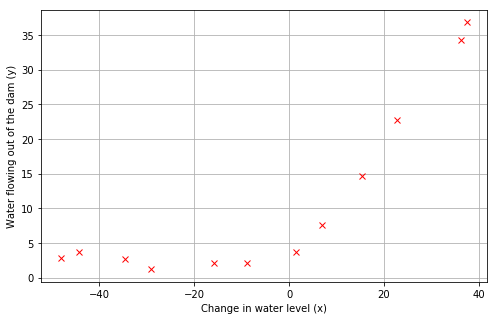

In [30]:
def plotData():
    plt.figure(figsize=(8,5))
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (x)')
    plt.plot(X_train[:,1],y_train,'rx')
    plt.grid(True)
    
plotData()

In [31]:
def linearRegCostFunction(theta, X, y, reg):
    m = y.size
    
    h = X.dot(theta)
    
    J = (1/(2*m))*np.sum(np.square(h-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
   
    return(J)



In [32]:
def lrgradientReg(theta, X, y, reg):
    m = y.size
    
    h = X.dot(theta.reshape(-1,1))
        
    grad = (1/m)*(X.T.dot(h-y))+ (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [33]:


initial_theta = np.ones((X_train.shape[1],1))
cost = linearRegCostFunction(initial_theta, X_train, y_train, 0)
gradient = lrgradientReg(initial_theta, X_train, y_train, 0)
print(cost)
print(gradient)



303.9515255535976
[-15.30301567 598.16741084]


In [34]:
def trainLinearReg(X, y, reg):
    #initial_theta = np.zeros((X.shape[1],1))
    initial_theta = np.array([[15],[15]])
    # For some reason the minimize() function does not converge when using
    # zeros as initial theta.
        
    res = minimize(linearRegCostFunction, initial_theta, args=(X,y,reg), method=None, jac=lrgradientReg,
                   options={'maxiter':5000})
    
    return(res)

fit = trainLinearReg(X_train, y_train, 0)
fit



      fun: 1604.4002999186634
 hess_inv: array([[1.03142187, 0.00617881],
       [0.00617881, 0.001215  ]])
      jac: array([ 3.42437190e-12, -5.70371898e-10])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([13.08790351,  0.36777923])

In [35]:
#Comparison: coefficients and cost obtained with LinearRegression in Scikit-learn

regr = LinearRegression(fit_intercept=False)
regr.fit(X_train, y_train.ravel())
print(regr.coef_)
print(linearRegCostFunction(regr.coef_, X_train, y_train, 0))



[13.08790351  0.36777923]
1604.400299921103


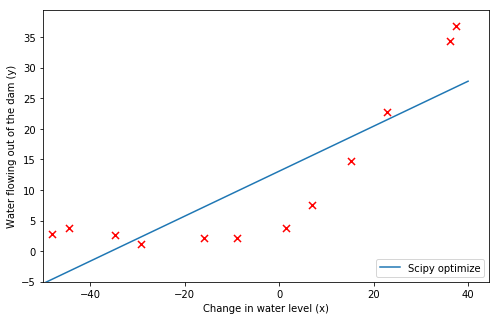

In [36]:
plt.figure(figsize=(8,5))
plt.plot(np.linspace(-50,40), (fit.x[0]+ (fit.x[1]*np.linspace(-50,40))), label='Scipy optimize')
#plt.plot(np.linspace(-50,40), (regr.coef_[0]+ (regr.coef_[1]*np.linspace(-50,40))), label='Scikit-learn')
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.ylim(ymin=-5)
plt.xlim(xmin=-50)
plt.legend(loc=4)




In [37]:
def learningCurve(X, y, Xval, yval, reg):
    m = y.size
    
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    
    for i in np.arange(m):
        res = trainLinearReg(X[:i+1], y[:i+1], reg)
        error_train[i] = linearRegCostFunction(res.x, X[:i+1], y[:i+1], reg)
        error_val[i] = linearRegCostFunction(res.x, Xval, yval, reg)
    
    return(error_train, error_val)

t_error, v_error = learningCurve(X_train, y_train, Xval, yval, 0)





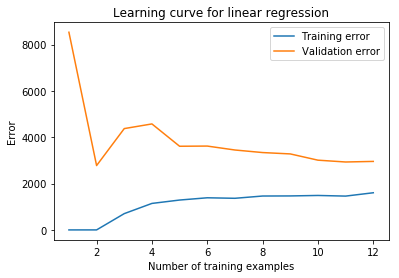

In [38]:
plt.plot(np.arange(1,13), t_error, label='Training error')
plt.plot(np.arange(1,13), v_error, label='Validation error')
plt.title('Learning curve for linear regression')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend();

# Polynomial regression

In [43]:
def genPolyFeatures(myX,p):
    """
    Function takes in the X matrix (with bias term already included as the first column)
    and returns an X matrix with "p" additional columns.
    The first additional column will be the 2nd column (first non-bias column) squared,
    the next additional column will be the 2nd column cubed, etc.
    """
    newX = myX.copy()
    for i in range(p):
        dim = i+2
        newX = np.insert(newX,newX.shape[1],np.power(newX[:,1],dim),axis=1)
    return newX

def featureNormalize(myX):
    """
    Takes as input the X array (with bias "1" first column), does
    feature normalizing on the columns (subtract mean, divide by standard deviation).
    Returns the feature-normalized X, and feature means and stds in a list
    Note this is different than my implementation in assignment 1...
    I didn't realize you should subtract the means, THEN compute std of the
    mean-subtracted columns.
    Doesn't make a huge difference, I've found
    """
   
    Xnorm = myX.copy()
    stored_feature_means = np.mean(Xnorm,axis=0) #column-by-column
    Xnorm[:,1:] = Xnorm[:,1:] - stored_feature_means[1:]
    stored_feature_stds = np.std(Xnorm,axis=0,ddof=1)
    Xnorm[:,1:] = Xnorm[:,1:] / stored_feature_stds[1:]
    return Xnorm, stored_feature_means, stored_feature_stds

In [46]:
#Generate an X matrix with terms up through x^8
#(7 additional columns to the X matrix)

###############################################################
# My d=8 plot doesn't match the homework pdf, due to differences
# between scipy.optimize.fmin_cg and the octave version
# I see that in subokita's implementation, for fitting he gets the
# same results as I when using scipy.optimize.fmin_cg
# 
# The d=5 plot (up through x^6) shows overfitting clearly, so I'll
# continue using that
###############################################################

global_d = 5
newX = genPolyFeatures(X_train,global_d)
newX_norm, stored_means, stored_stds = featureNormalize(newX)
#Find fit parameters starting with 1's as the initial guess
mytheta = np.ones((newX_norm.shape[1],1))


fit_theta = trainLinearReg(newX_norm,y_train,0.)

ValueError: shapes (12,7) and (2,1) not aligned: 7 (dim 1) != 2 (dim 0)

In [ ]:


def plotFit(fit_theta,means,stds):
    """
    Function that takes in some learned fit values (on feature-normalized data)
    It sets x-points as a linspace, constructs an appropriate X matrix,
    un-does previous feature normalization, computes the hypothesis values,
    and plots on top of data
    """
    n_points_to_plot = 50
    xvals = np.linspace(-55,55,n_points_to_plot)
    xmat = np.ones((n_points_to_plot,1))
    
    xmat = np.insert(xmat,xmat.shape[1],xvals.T,axis=1)
    xmat = genPolyFeatures(xmat,len(fit_theta)-2)
    #This is undoing feature normalization
    xmat[:,1:] = xmat[:,1:] - means[1:]
    xmat[:,1:] = xmat[:,1:] / stds[1:]
    plotData()
    plt.plot(xvals,h(fit_theta,xmat),'b--')

plotFit(fit_theta,stored_means,stored_stds)



In [ ]:
def plotPolyLearningCurve(mylambda=0.):

    initial_theta = np.ones((global_d+2,1))
    mym, error_train, error_val = [], [], []
    myXval, dummy1, dummy2 = featureNormalize(genPolyFeatures(Xval,global_d))

    for x in xrange(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        train_subset = genPolyFeatures(train_subset,global_d)   
        train_subset, dummy1, dummy2 = featureNormalize(train_subset)
        fit_theta = optimizeTheta(initial_theta,train_subset,y_subset,mylambda=mylambda,print_output=False)
        error_train.append(computeCost(fit_theta,train_subset,y_subset,mylambda=mylambda))
        error_val.append(computeCost(fit_theta,myXval,yval,mylambda=mylambda))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve (lambda = 0)')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plotPolyLearningCurve()

In [ ]:
#Try Lambda = 1
mytheta = np.zeros((newX_norm.shape[1],1))
fit_theta = optimizeTheta(mytheta,newX_norm,y,1)
plotFit(fit_theta,stored_means,stored_stds)
plotPolyLearningCurve(1.)


In [ ]:
#Try Lambda = 100
#Note after one iteration, the lambda of 100 penalizes the theta params so hard
#that the minimizer loses precision and gives up...
#so the plot below is NOT indicative of a successful fit
mytheta = np.random.rand(newX_norm.shape[1],1)
fit_theta = optimizeTheta(mytheta,newX_norm,y,100.)
plotFit(fit_theta,stored_means,stored_stds)

In [ ]:
#lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
lambdas = np.linspace(0,5,20)
errors_train, errors_val = [], []
for mylambda in lambdas:
    newXtrain = genPolyFeatures(X,global_d)
    newXtrain_norm, dummy1, dummy2 = featureNormalize(newXtrain)
    newXval = genPolyFeatures(Xval,global_d)
    newXval_norm, dummy1, dummy2 = featureNormalize(newXval)
    init_theta = np.ones((newX_norm.shape[1],1))
    fit_theta = optimizeTheta(mytheta,newXtrain_norm,y,mylambda,False)
    errors_train.append(computeCost(fit_theta,newXtrain_norm,y,mylambda=mylambda))
    errors_val.append(computeCost(fit_theta,newXval_norm,yval,mylambda=mylambda))

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(lambdas,errors_train,label='Train')
plt.plot(lambdas,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)